In [31]:
import osmnx as ox
import pandas as pd
import numpy as np
import import_ipynb
from astar import astar
import Graph

In [5]:
pd.set_option("display.max_columns", 20)
pd.set_option('display.max_colwidth', 20)

**▶ Load Ulsan nodes and links data from osmnx module (it takes a while)**

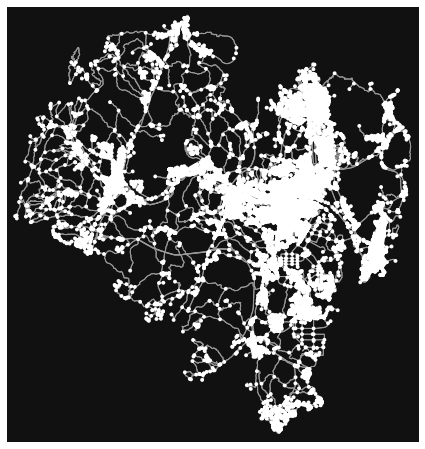

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [6]:
ulsan = ox.graph_from_place("Ulsan, Korea")
ox.plot_graph(ulsan)

<AxesSubplot:>

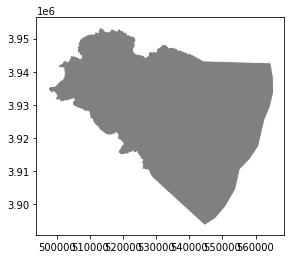

In [7]:
shape = ox.geocode_to_gdf("Ulsan, Korea")
Ulsan_shape = ox.project_gdf(shape)
Ulsan_shape.plot(fc='gray', ec='w')

**▶ Data preprocessing** 

In [11]:
nodes_data, links_data = ox.graph_to_gdfs(ulsan)

In [12]:
nodes_data.head()

,y,x,street_count,ref,highway,geometry
osmid,,,,,,
259986397,35.404426,129.345971,4,NaN,NaN,POINT (129.34597...
310741234,35.709331,129.190105,3,NaN,NaN,POINT (129.19010...
310741298,35.710516,129.190694,3,8,motorway_junction,POINT (129.19069...
414673699,35.595460,129.031500,3,NaN,NaN,POINT (129.03150...
414673783,35.491256,129.229637,4,NaN,traffic_signals,POINT (129.22964...


In [13]:
links_data.head()

osmid lanes    name        highway  \
u         v          key                                                     
259986397 5303033158 0              778164558     2     공단로        primary   
          7756230716 0    [778164560, 7781...   NaN     NaN        primary   
          7756230733 0              778164561     2     공단로      secondary   
310741234 9174052256 0    [44673376, 44673...     2  경부고속도로       motorway   
310741298 6263378132 0              668834526   NaN     NaN  motorway_link   

                          oneway     length  ref             geometry  \
u         v          key                                                
259986397 5303033158 0     False     15.576  NaN  LINESTRING (129....   
          7756230716 0      True    196.557   31  LINESTRING (129....   
          7756230733 0     False    807.398   51  LINESTRING (129....   
310741234 9174052256 0      True  13446.453    1  LINESTRING (129....   
310741298 6263378132 0      True    275.574  NaN  LINESTRING (129....   

                         maxspeed bridge tunnel service width access junction  
u         v          key                                                       
259986397 5303033158 0        NaN    NaN    NaN     NaN   NaN    NaN      NaN  
          7756230716 0        NaN    NaN    NaN     NaN   NaN    NaN      NaN  
          7756230733 0        NaN    NaN    NaN     NaN   NaN    NaN      NaN  
310741234 9174052256 0        100    yes    NaN     NaN   NaN    NaN      NaN  
310741298 6263378132 0        NaN    NaN    NaN     NaN   NaN    NaN      NaN

In [14]:
# nodes = nodes_data.reset_index()
# nodes.rename(columns={'osmid':'node_id', 'y':'ycoord', 'x':'xcoord'}, inplace=True)

# # node dictionary for latitude and longitude
# node_dict = {}
# for i in range(len(nodes)):
#     node_dict[nodes.loc[i].node_id] = (nodes.loc[i].xcoord, nodes.loc[i].ycoord)
    
# links = links_data.reset_index()
# links.rename(columns={'u':'begin_node_id', 'v':'end_node_id', 'length':'street_length'}, inplace=True)

# # Creat coordinate columns for start node and end node
# startX = []
# startY = []
# endX = []
# endY = []
# for i in range(len(links)):
#     startX.append(node_dict[links.loc[i].begin_node_id][0])
#     startY.append(node_dict[links.loc[i].begin_node_id][1])
#     endX.append(node_dict[links.loc[i].end_node_id][0])
#     endY.append(node_dict[links.loc[i].end_node_id][1])
    
# links['startX'] = startX
# links['startY'] = startY
# links['endX'] = endX
# links['endY'] = endY

# nodes.to_csv('Ulsan_nodes.csv')
# links.to_csv('Ulsan_edges.csv')

In [8]:
# # Find the nearest node given longitude and latitude
# def nearest_node(x, y):
#     min_dist = np.inf
#     for i in range(len(nodes)):
#         dist = np.sqrt((x - nodes['xcoord'][i])**2 + (y - nodes['ycoord'][i])**2)
#         if dist < min_dist:
#             min_dist = dist
#             idx = i
#     return nodes['node_id'][idx]

In [9]:
# nearest_node(129.2959, 35.529)

**▶ Astar algorithm in Ulsan**

In [15]:
graph = graph.make_graph('./roadnetwork_data/Ulsan_nodes.csv', './roadnetwork_data/Ulsan_edges.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


>>> Graph creating time: 4.033478736877441


In [32]:
def visualize_with_folium(route, extended_node):
    import folium
    import pandas as pd
    import numpy as np

    # 탐색노드, 경로 DataFrame생성
    start_node = route[0:-1]
    end_node = route[1:-1] + [route[-1]]

    # Creating start-end pairs dataframe
    route_data = pd.DataFrame(start_node, columns = ['begin_node_id'])
    route_data['end_node_id'] = end_node

    # start-end pairs로 이루어진 road network 정보 dataframe
    routes = pd.merge(route_data, links, on = ['begin_node_id', 'end_node_id'])

    expanded_node = []
    for i in extended_node:
        expanded_node.append(i.id)

    # 탐색노드 dataframe만들기
    node_data = pd.DataFrame(expanded_node, columns = ['node_id'])
    nodes_data = pd.merge(node_data, nodes, on = ['node_id'])

    
    
    # Visualization
    # Load map
    # location=(latitude, longitude)
    map_f = folium.Map(location=[routes.loc[len(routes)//2].startY, routes.loc[len(routes)//2].startX], zoom_start=11)

    points = []
    # Expanded nodes
    for i in range(len(nodes_data)):
        folium.Circle(radius=10, location=[nodes_data.loc[i].ycoord, nodes_data.loc[i].xcoord],
                      color="blue", fill=True).add_to(map_f)

    points = []
    # Route
    for i in range(len(routes)):
        points.append([routes.loc[i].startY, routes.loc[i].startX])
    points.append([routes.loc[i].endY, routes.loc[i].endX])
    folium.PolyLine(points, color = "red", weight = 3, opacity=1).add_to(map_f)

    # start, target position
    folium.Marker([routes.loc[0].startY,routes.loc[0].startX], popup="Start",
                  icon=folium.Icon(icon="star", color="green")).add_to(map_f)
    folium.Marker([routes.loc[len(routes)-1].startY,routes.loc[len(routes)-1].startX], popup="Target",
                  icon=folium.Icon(icon="star", color="red")).add_to(map_f)

    return map_f

In [33]:
# From UNIST to UlsanGrandPark
route, extended_node = astar(graph, 259986397, 9135501698)

# map_f = visualize_with_folium(route, extended_node)
map_f = visualize_with_folium(route, extended_node)
map_f

[Astar algorithm]
>>> distance cost is: 16452.936000000005
>>> #iteration:  797
>>> #expanded nodes: 797
>>> execution time:  0.012104511260986328
